<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/15-processing-sequences-using-RNNs-CNNs/2_forecasting_time_series_several_steps_ahead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Several Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to be the value 10 steps ahead instead of 1 step ahead).

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on.

## Setup

In [0]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
  IS_COLAB = True
except Exception:
  IS_COLAB = False
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

TensorFlow 2.x selected.


## Generate the Dataset

For simplicity, we are using a time series generated by the generate_time_series() function.

In [0]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)

  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))      # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)       # + noise

  return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the batch_size argument), each of length n_steps , and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape [ batch size , time steps , 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [ batch size , time steps , dimensionality ], where dimensionality is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

X_train, y_train = series[:7000, : n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

In [0]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

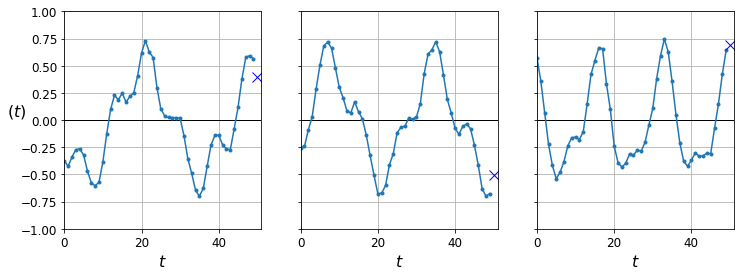

In [0]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
  plt.plot(series, '.-')

  if y is not None:
    plt.plot(n_steps, y, 'bx', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred , 'ro')
  plt.grid(True)

  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)

  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$(t)$' if col==0 else None))

plt.show()

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models.

For example, the simplest approach is to predict the last value in each series. This is called naive forecasting , and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [0]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_absolute_error(y_valid, y_pred))

0.11627829

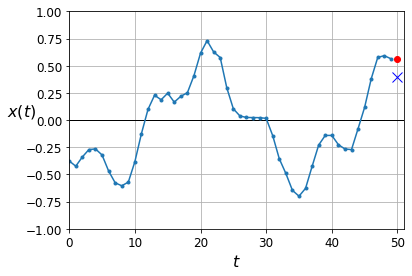

In [0]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. 

Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)                           
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 378us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 1s 76us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 1s 75us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 1s 80us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 1s 81us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 82us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 76us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 1s 83us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [0]:
model.evaluate(X_valid, y_valid, verbose=0)

0.004145486194640398

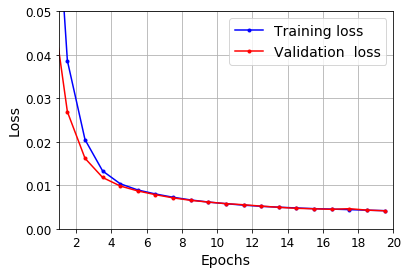

In [0]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
  plt.plot(np.arange(len(val_loss)) + 0.5, val_loss, 'r.-', label='Validation  loss')

  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

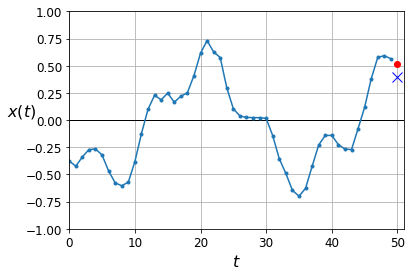

In [0]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

we get an MSE of about 0.004. That’s much better than the naive approach!

## Forecasting Several Steps

In [0]:
np.random.seed(43)  # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [0]:
Y_pred.shape

(1, 10, 1)

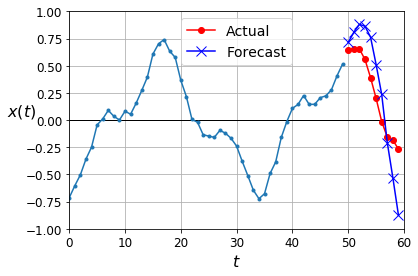

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label='Actual')
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'bx-', label='Forecast', markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

As you might expect, the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate.

In [0]:
np.random.seed(42)

series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [0]:
X = X_valid
for step_ahead in range(10):
  y_pred_one = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [0]:
Y_pred.shape

(2000, 10)

In [0]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.02727729

If you evaluate this approach on the validation set, you will find an MSE of about 0.029. This is much higher than the previous models, but it’s also a much harder task, so the comparison doesn’t mean much. It’s much more meaningful to compare this performance with naive predictions (just forecasting that the time series will remain constant for 10 time steps) or with a simple linear model.

In [0]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848


 The naive approach is terrible (it gives an MSE of about 0.223), but the linear model gives an MSE of about 0.0188: it’s much better than using our RNN to forecast the future one step at a time, and also much faster to train and run. Still, if you only want to forecast a few time steps ahead, on more complex tasks, this approach may work well.

The second option is to train an RNN to predict all 10 next values at once. We can still use a sequence-to-vector model, but it will output 10 values instead of 1. However, we first need to change the targets to be vectors containing the next 10 values:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.Flatten(input_shape=[50, 1]),
   keras.layers.Dense(10)                              
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 114us/sample - loss: 0.1348 - val_loss: 0.0610
Epoch 2/20
7000/7000 [==============================] - 1s 85us/sample - loss: 0.0501 - val_loss: 0.0427
Epoch 3/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0388 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0334 - val_loss: 0.0314
Epoch 5/20
7000/7000 [==============================] - 1s 85us/sample - loss: 0.0299 - val_loss: 0.0286
Epoch 6/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0275 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 1s 85us/sample - loss: 0.0258 - val_loss: 0.0251
Epoch 8/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0245 - val_loss: 0.0237
Epoch 9/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

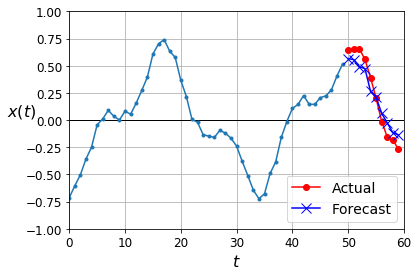

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.SimpleRNN(20),
   keras.layers.Dense(10)                              
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0138 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0132 - val_loss: 0.0117
Epoch 7/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0115 - val_loss: 0.0119
Epoch 9/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0110 - val_loss: 0.0113
Epoch 1

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

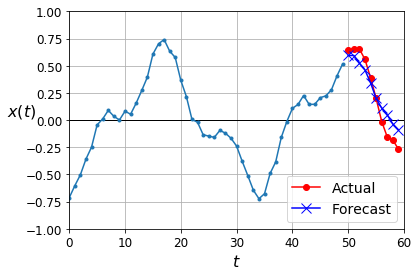

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [0]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step. Keras offers a TimeDistributed layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.SimpleRNN(20, return_sequences=True),
   keras.layers.TimeDistributed(keras.layers.Dense(10))                              
])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0388 - last_time_step_mse: 0.0280 - val_loss: 0.0324 - val_last_time_step_mse: 0.0196
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0324 - last_time_step_mse: 0.0212 - val_loss: 0.0312 - val_last_time_step_mse: 0.0209
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0297 - last_time_step_mse: 0.0185 - val_loss: 0.0279 - val_last_time_step_mse: 0.0164
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0270 - last_time_step_mse: 0.0151 - val_loss: 0.0265 - val_last_time_step_mse: 0.0153
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0242 - last_time_step_mse: 0.0115 - 

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

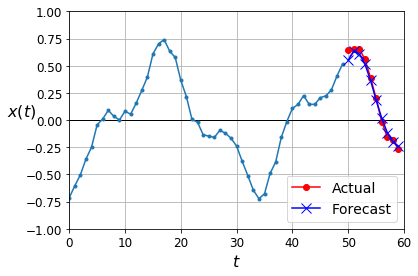

In [0]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()